<a href="https://colab.research.google.com/github/sleepypioneer/machine-learning-zoomcamp/blob/main/notebooks/homework_week_8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import shutil
import os

import numpy as np
import matplotlib.pyplot as plt
import statistics

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.applications.xception import preprocess_input
from tensorflow.keras.applications.xception import decode_predictions
from tensorflow.keras.layers import Conv2D, Dense, Dropout, Flatten, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import load_img

%matplotlib inline

In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [3]:
data_path = "/content/dogs_and_cats"

raw_path = f"{data_path}/raw_data"
train_path = f"{data_path}/train"
validation_path = f"{data_path}/validation"


In [4]:
os.mkdir(data_path)
os.mkdir(raw_path)

!wget https://github.com/alexeygrigorev/large-datasets/releases/download/dogs-cats/train.zip

!unzip /content/train.zip -d /content/dogs_and_cats/raw_data

Streaming output truncated to the last 5000 lines.
  inflating: /content/dogs_and_cats/raw_data/train/dog.5499.jpg  
  inflating: /content/dogs_and_cats/raw_data/train/dog.55.jpg  
  inflating: /content/dogs_and_cats/raw_data/train/dog.550.jpg  
  inflating: /content/dogs_and_cats/raw_data/train/dog.5500.jpg  
  inflating: /content/dogs_and_cats/raw_data/train/dog.5501.jpg  
  inflating: /content/dogs_and_cats/raw_data/train/dog.5502.jpg  
  inflating: /content/dogs_and_cats/raw_data/train/dog.5503.jpg  
  inflating: /content/dogs_and_cats/raw_data/train/dog.5504.jpg  
  inflating: /content/dogs_and_cats/raw_data/train/dog.5505.jpg  
  inflating: /content/dogs_and_cats/raw_data/train/dog.5506.jpg  
  inflating: /content/dogs_and_cats/raw_data/train/dog.5507.jpg  
  inflating: /content/dogs_and_cats/raw_data/train/dog.5508.jpg  
  inflating: /content/dogs_and_cats/raw_data/train/dog.5509.jpg  
  inflating: /content/dogs_and_cats/raw_data/train/dog.551.jpg  
  inflating: /content/dogs_an

In [5]:
# clean up downloaded zip
!rm -r /content/train.zip

In [6]:
def create_train_and_validate_directories():
  os.mkdir(train_path)
  os.mkdir(validation_path)
  os.mkdir(f"{train_path}/cats")
  os.mkdir(f"{train_path}/dogs")
  os.mkdir(f"{validation_path}/cats")
  os.mkdir(f"{validation_path}/dogs")


# script to split training and validation data and move it into the corresponding directories
def split_raw_data_to_test_and_train():
  for n in range(0, 10000):
      shutil.move(f"{raw_path}/train/cat.{n}.jpg", f"{train_path}/cats")
      shutil.move(f"{raw_path}/train/dog.{n}.jpg", f"{train_path}/dogs")

  print("Training files moved")

  for n in range(10000, 12500):
      shutil.move(f"{raw_path}/train/cat.{n}.jpg", f"{validation_path}/cats")
      shutil.move(f"{raw_path}/train/dog.{n}.jpg", f"{validation_path}/dogs")
  
  print("Validation files moved")


create_train_and_validate_directories()
split_raw_data_to_test_and_train()

Training files moved
Validation files moved


In [7]:
def make_model(input_shape=(150, 150, 3), filters=32, kernel_size=(3, 3),
               pooling_size=(2, 2), learning_rate=0.002, size_inner=64,
               droprate=0.5):

    base_model = tf.keras.models.Sequential()
    
    Xception(
        weights='imagenet',
        include_top=False,
        input_shape=input_shape
    )

    base_model.trainable = False


    #########################################

    inputs = keras.Input(shape=input_shape)
    base = base_model(inputs, training=False)
    conv = Conv2D(
      filters,
      kernel_size,
      activation='relu', 
      input_shape=input_shape
    )(base)

    pooling = MaxPooling2D(
        pool_size=pooling_size,
        input_shape=input_shape
    )(conv)

    vectors = Flatten()(pooling)
    
    inner = Dense(size_inner, activation='relu')(vectors)
    drop = Dropout(droprate)(inner)
    
    outputs = Dense(1, activation='sigmoid')(drop)
    
    model = keras.Model(inputs, outputs)
    
    #########################################

    optimizer = keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.8)
    loss = keras.losses.BinaryCrossentropy()

    model.compile(
        optimizer=optimizer,
        loss=loss,
        metrics=['accuracy']
    )
    
    return model

In [8]:
input_shape = (150, 150, 3)
filter = 32
kernel_size = (3, 3) # size of the filter
pooling_size = (2, 2)
size_inner = 64
learning_rate = 0.002
droprate = 0.5

In [9]:
model = make_model(input_shape, 32, (3, 3), (2, 2), 0.002, 64, 0.5)

83697664/83683744 [==============================] - 1s 0us/step


In [10]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 sequential (Sequential)     multiple                  0         
                                                                 
 conv2d_4 (Conv2D)           (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 32)       0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 175232)            0         
                                                                 
 dense (Dense)               (None, 64)                11214912  
                                                             

In [11]:
train_generator = ImageDataGenerator(rescale=1./255)

train_ds = train_generator.flow_from_directory(
    train_path,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary'
)

train_ds.class_indices

Found 20000 images belonging to 2 classes.


{'cats': 0, 'dogs': 1}

In [12]:
validation_generator = ImageDataGenerator(rescale=1./255)

val_ds = validation_generator.flow_from_directory(
    validation_path,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary'
)

Found 5000 images belonging to 2 classes.


In [13]:
%%time

history = model.fit(
    train_ds,
    steps_per_epoch=100,
    epochs=10,
    validation_data=val_ds,
    validation_steps=50
)

Epoch 1/10
100/100 [==============================] - 43s 127ms/step - loss: 0.7035 - accuracy: 0.5205 - val_loss: 0.6926 - val_accuracy: 0.5140
Epoch 2/10
100/100 [==============================] - 10s 103ms/step - loss: 0.6918 - accuracy: 0.5420 - val_loss: 0.6920 - val_accuracy: 0.4930
Epoch 3/10
100/100 [==============================] - 12s 124ms/step - loss: 0.6903 - accuracy: 0.5325 - val_loss: 0.6908 - val_accuracy: 0.5440
Epoch 4/10
100/100 [==============================] - 10s 104ms/step - loss: 0.6924 - accuracy: 0.5095 - val_loss: 0.6895 - val_accuracy: 0.5810
Epoch 5/10
100/100 [==============================] - 10s 104ms/step - loss: 0.6902 - accuracy: 0.5345 - val_loss: 0.6932 - val_accuracy: 0.4770
Epoch 6/10
100/100 [==============================] - 11s 108ms/step - loss: 0.6900 - accuracy: 0.5235 - val_loss: 0.6872 - val_accuracy: 0.5420
Epoch 7/10
100/100 [==============================] - 11s 108ms/step - loss: 0.6878 - accuracy: 0.5200 - val_loss: 0.6847 - val_ac

In [14]:
statistics.median(history.history["accuracy"])

0.5335000157356262

In [15]:
statistics.stdev(history.history["loss"])

0.006156656446943167

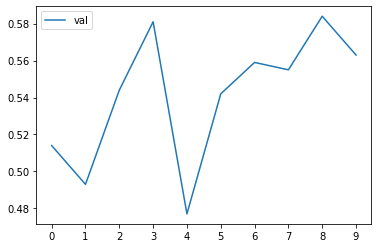

In [16]:
plt.plot(history.history['val_accuracy'], label='val')
plt.xticks(np.arange(10))
plt.legend()

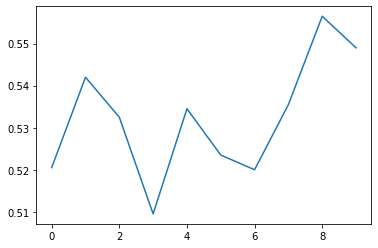

In [17]:
plt.plot(history.history['accuracy'], label='train')

In [18]:
train_generator_2 = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_ds_2 = train_generator_2.flow_from_directory(
    train_path,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary'
)

Found 20000 images belonging to 2 classes.


In [19]:
validation_generator_2 = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_ds_2 = validation_generator_2.flow_from_directory(
    validation_path,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary'
)

Found 5000 images belonging to 2 classes.


In [20]:
%%time

history_2 = model.fit(
    train_ds_2,
    steps_per_epoch=100,
    epochs=10,
    validation_data=val_ds_2,
    validation_steps=50
)

Epoch 1/10
100/100 [==============================] - 28s 277ms/step - loss: 0.6863 - accuracy: 0.5410 - val_loss: 0.6821 - val_accuracy: 0.5760
Epoch 2/10
100/100 [==============================] - 27s 276ms/step - loss: 0.6900 - accuracy: 0.5325 - val_loss: 0.6819 - val_accuracy: 0.5650
Epoch 3/10
100/100 [==============================] - 28s 277ms/step - loss: 0.6873 - accuracy: 0.5455 - val_loss: 0.6826 - val_accuracy: 0.5770
Epoch 4/10
100/100 [==============================] - 27s 275ms/step - loss: 0.6843 - accuracy: 0.5425 - val_loss: 0.6879 - val_accuracy: 0.5310
Epoch 5/10
100/100 [==============================] - 28s 277ms/step - loss: 0.6867 - accuracy: 0.5490 - val_loss: 0.6788 - val_accuracy: 0.5660
Epoch 6/10
100/100 [==============================] - 25s 255ms/step - loss: 0.6824 - accuracy: 0.5570 - val_loss: 0.6766 - val_accuracy: 0.5600
Epoch 7/10
100/100 [==============================] - 25s 251ms/step - loss: 0.6833 - accuracy: 0.5460 - val_loss: 0.6845 - val_ac

In [21]:
statistics.mean(history.history["val_loss"])

0.6871279180049896

In [22]:
statistics.mean(history.history["val_accuracy"][5:])

0.5606000065803528